# 利用胶囊网络解决MNIST分类问题
- 作者 : *Jinhong Du*

- 参考资料: 
    
    1. https://arxiv.org/pdf/1710.09829.pdf
    2. https://github.com/naturomics/CapsNet-Tensorflow/
    3. https://www.jiqizhixin.com/articles/2017-11-05

# 目录

1. [导入相关包](#Sec1)
2. [设置超参数](#Sec2)
3. [准备数据](#Sec3)
    - [导入数据](#Sec3.1)
    - [数据预处理](#Sec3.1)
    - [生成Dataset](#Sec3.1) 
4. [建立模型](#Sec4)
    - [Squash函数](#Sec4.1)
    - [Routing函数](#Sec4.2)
    - [Primary Capsules](#Sec4.3)
    - [Digit Capsules](#Sec4.4)
    - [建立CapsNet模型](#Sec4.5)
    - [损失函数](#Sec4.6) 
    - [优化器](#Sec4.7)
    - [训练与评估](#Sec4.8)    

## 1. 导入相关包<a id='Sec1'></a>

In [1]:
# 启动eager execution模式，必须在项目开始时运行
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

## 2. 设置超参数<a id='Sec2'></a>

In [2]:
NUM_CLASS = 10
NUM_EPOCH = 10
BATCH_SIZE = 128

## 3. 准备数据<a id='Sec3'></a>

### 3.1. 导入数据<a id='Sec3.1'></a>

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path=r'C:\Users\Administrator\Downloads\mnist.npz')

print('Training set:')
print('       Data :\t shape:', np.shape(x_train), '\t type:', x_train.dtype)
print('       Label:\t shape:', np.shape(y_train), '\t\t type:', y_train.dtype)
print('Testing set :')
print('       Data :\t shape:', np.shape(x_test), '\t type:', x_test.dtype)
print('       Label:\t shape:', np.shape(y_test), '\t\t type:', y_test.dtype)

Training set:
       Data :	 shape: (60000, 28, 28) 	 type: uint8
       Label:	 shape: (60000,) 		 type: uint8
Testing set :
       Data :	 shape: (10000, 28, 28) 	 type: uint8
       Label:	 shape: (10000,) 		 type: uint8


### 3.2. 数据预处理<a id='Sec3.2'></a>

In [4]:
# 转化为浮点型并归一化
x_train = np.reshape(x_train.astype(np.float32)/255,(-1,28,28,1))
x_test = np.reshape(x_test.astype(np.float32)/255,(-1,28,28,1))
print(np.shape(x_train), np.shape(x_test))

# 将标签转化为ont-hot向量
y_train = tf.one_hot(y_train, NUM_CLASS, dtype=tf.float32)
y_test = tf.one_hot(y_test, NUM_CLASS, dtype=tf.float32)
print(y_train, y_test)

(60000, 28, 28, 1) (10000, 28, 28, 1)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]], shape=(60000, 10), dtype=float32) tf.Tensor(
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(10000, 10), dtype=float32)


### 3.3. 生成Dataset<a id='Sec3.3'></a>

In [5]:
# 生成用于训练的Dataset
TrainDataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# 按buffer_size打乱
TrainDataset = TrainDataset.shuffle(buffer_size=5000)
# 设置Batch size，若最后一个batch不足BATCH_SIZE个则丢弃
TrainDataset = TrainDataset.batch(BATCH_SIZE, drop_remainder=True)

# 生成用于测试的Dataset
TestDataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE, drop_remainder=True)

## 4. 建立模型<a id='Sec4'></a>

### 4.1 Squash函数<a id='Sec4.1'></a>

In [6]:
def squash(vector):
    '''Squashing函数
    Args:
        vector: A tensor with shape [batch_size, 1, num_caps, vec_len, 1] or [batch_size, num_caps, vec_len, 1].
    Returns:
        A tensor with the same shape as vector but squashed in 'vec_len' dimension.
    '''
    epsilon = 1e-9
    # 计算向量的模
    vec_squared_norm = tf.reduce_sum(tf.square(vector), -2, keepdims=True)
    # 计算标准化的系数
    scalar_factor = vec_squared_norm / (1 + vec_squared_norm) / tf.sqrt(vec_squared_norm + epsilon)
    # 逐元素乘积
    vec_squashed = scalar_factor * vector  
    return(vec_squashed)

### 4.2 Routing函数<a id='Sec4.2'></a>

In [7]:
def routing(input_tensor, b, W, biases, num_caps_out=10, num_dims=16, iteration=3):
    ''' The routing algorithm.
    Args:
        input_tensor - A tensor with [batch_size, num_caps_in=1152, 1, length(u_i)=8, 1]
                        shape, num_caps_in meaning the number of capsule in layer l, i.e. 
                        the preceding layer.
        b            - A tensor with all values being zeros and [1, num_caps_in, 
                        num_caps_out] shape. 
        W            - A tensor with [1, num_caps_in, num_caps_out * len_v_j, len_u_j, 1]
                        shape. 
        num_caps_out - The number of output capsules.
        num_dims     - The number of dimensions for output capsule.
    Returns:
        A Tensor of shape [batch_size, num_caps_l_plus_1, length(v_j)=16, 1]
        representing the vector output `v_j` in the layer l+1
    Notes:
        u_i represents the vector output of capsule i in the layer l, and
        v_j the vector output of capsule j in the layer l+1.
     '''

    input_shape = tf.shape(input_tensor)
    # [batch_size, 1152, 160, 8, 1]
    
    # Eq.2, 计算u_hat
    # 因为tf.matmul操作比较耗时，我们可以尝试用逐元素相乘来计算：
    # 形状为[a, b]、[b, c]的两矩阵相乘 <=> 先将形状复制为[a*c, b]、[b, a*c]，再将第二个矩阵转置，
    # 两者逐元素相乘后再对axis=1求和，并reshape为[a, c]
    input_tensor = tf.tile(input_tensor, [1, 1, num_dims * num_caps_out, 1, 1])
    u_hat = tf.reduce_sum(W * input_tensor, axis=3, keepdims=True)
    u_hat = tf.reshape(u_hat, shape=[-1, input_shape[1], num_caps_out, num_dims, 1])
    # [batch_size, 1152, 10, 16, 1]

    # u_hat_stopped = u_hat用于routing算法，不计算其梯度
    u_hat_stopped = tf.stop_gradient(u_hat, name='stop_gradient')

    # line 3, 开始迭代
    for r_iter in range(iteration):
        # line 4:
        c_IJ = tf.nn.softmax(b, axis=2)
        # [batch_size, 1152, 10, 1, 1]
        
        # 在最后一次迭代，用`u_hat`来连接后续网络
        if r_iter == iteration - 1:
            # line 5:
            # 用c_IJ作为权重计算u_hat的加权和s_J, c_IJ*u_hat最后两个维度逐元素相乘 
            s_J = tf.multiply(c_IJ, u_hat)
            # [batch_size, 1152, 10, 16, 1]
            
            s_J = tf.reduce_sum(s_J, axis=1, keepdims=True) + biases
            # [batch_size, 1, 10, 16, 1]

            # line 6:
            # squash
            v_J = squash(s_J)
            # [batch_size, 1, 10, 16, 1]
            
        # 最后一次迭代之前不需要反向传播误差，用u_hat_stopped
        elif r_iter < iteration - 1:  
            s_J = tf.multiply(c_IJ, u_hat_stopped)
            s_J = tf.reduce_sum(s_J, axis=1, keepdims=True) + biases
            v_J = squash(s_J)

            # line 7:
            # reshape & tile v_j from [batch_size ,1, 10, 16, 1] to [batch_size, 1152, 10, 16, 1]
            v_J_tiled = tf.tile(v_J, [1, input_shape[1], 1, 1, 1])
            u_produce_v = tf.reduce_sum(u_hat_stopped * v_J_tiled, axis=3, keepdims=True)
            # [batch_size, 1152, 10, 1, 1]

            b += u_produce_v

    return(v_J)

### 4.3. Primary Capsules<a id='Sec4.3'></a>

In [8]:
class PrimaryCaps(object):
    def __init__(self, num_caps_out=32, vec_len=8):
        self.num_caps_out = num_caps_out
        self.vec_len = vec_len
        self.caps = [
            tf.layers.Conv2D(filters = self.num_caps_out, kernel_size = 9, strides = 2,
                             padding = 'valid', activation = None, name = 'PrimaryCaps_%d'%i) for i in range(self.vec_len)]
    
    def __call__(self, x):  
        batch_size = tf.shape(x)[0]
        capsules = []
        for i in range(self.vec_len):
            # 将一般卷积的结果张量拉平，并为添加到列表中
            caps_i = tf.reshape(self.caps[i](x), shape=(batch_size, -1, 1, 1))
            capsules.append(caps_i)

        # 合并为PrimaryCaps的输出张量，即6×6×32个长度为8的向量，合并后的维度为 [batch_size, 1152, 8, 1]
        capsules = tf.concat(capsules, axis=2)
        # 将每个Capsule 向量投入非线性函数squash进行缩放与激活
        capsules = squash(capsules)
        return capsules

### 4.4. Digit Capsules<a id='Sec4.4'></a>

In [9]:
class DigitCaps(object):
    def __init__(self, num_caps_out=10, vec_len=16):
        self.num_caps_out = num_caps_out
        self.vec_len = vec_len
        self.input_shape = [-1, 1152, 8, 1]
        
        self.W = tfe.Variable(
            tf.random_normal(shape=[1, self.input_shape[1], self.vec_len * self.num_caps_out] + self.input_shape[-2:],
            dtype=tf.float32, stddev=0.01), name = 'DigitCaps_W')
        self.biases = tfe.Variable(
            tf.zeros(shape=(1, 1, self.num_caps_out, self.vec_len, 1),
            dtype=tf.float32), name = 'DigitCaps_b')
    
    def __call__(self, input_tensor): 
        batch_size = tf.shape(input_tensor)[0]
        input_tensor = tf.reshape(input_tensor, shape=(batch_size, -1, 1, self.input_shape[-2], 1))
        b = tf.constant(tf.zeros([1, self.input_shape[1], self.num_caps_out, 1, 1], dtype=np.float32))
        capsules = routing(input_tensor, b, self.W, self.biases)
        # tf.squeeze去除为1的维度得到 DigitCaps 层的输出向量
        capsules = tf.squeeze(capsules, axis=1)
        return capsules

### 4.5. 建立CapsNet模型<a id='Sec4.5'></a>

In [10]:
class CapsNet(tf.keras.Model):
    def __init__(self, height=28, width=28, channels=1, num_label=NUM_CLASS):
        super(CapsNet, self).__init__()
        self.height = height
        self.width = width
        self.channels = channels
        self.num_label = num_label
        
        # 1st layer
        self.Conv1 = tf.layers.Conv2D(filters = 256, kernel_size = 9, strides = 1,
                                      padding = 'valid', activation = tf.nn.relu, name = 'Conv1')
        
        # 2nd layer - PrimaryCaps
        self.PrimaryCaps = PrimaryCaps(num_caps_out=32, vec_len=8)
  
        # 3rd layer - DigitCaps
        self.DigitCaps = DigitCaps(num_caps_out=10, vec_len=16)
        
        # 重构部分
        # 3个全连接层
        self.fc1 = tf.layers.Dense(
                            units=512,
                            activation=tf.nn.relu,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            bias_initializer=tf.zeros_initializer(),
                            name='fc1')
        self.fc2 = tf.layers.Dense(
                            units=1024,
                            activation=tf.nn.relu,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            bias_initializer=tf.zeros_initializer(),
                            name='fc2')    
        self.fc3 = tf.layers.Dense(
                            units=self.height * self.width * self.channels,
                            activation=tf.sigmoid,
                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                            bias_initializer=tf.zeros_initializer(),
                            name='fc3')
        
    def call(self, X, Y, reconstruct=False):
        epsilon = 1e-9
        batch_size = tf.shape(X)[0]
        
        conv1 = self.Conv1(X)
        # Output [batch_size, 1152, 8, 1]
        caps1 = self.PrimaryCaps(conv1)
        v = self.DigitCaps(caps1)
        
        # a). 计算v的模||v_c||，及softmax(||v_c||)
        # [batch_size, 10, 16, 1] => [batch_size, 10, 1, 1]
        v_length = tf.sqrt(tf.reduce_sum(tf.square(v),
                                               axis=2, keepdims=True) + epsilon)
        softmax_v = tf.nn.softmax(v_length, axis=1)
        # [batch_size, self.num_label, 1, 1]

        # b). 取出模最大对应的索引
        # [batch_size, 10, 1, 1] => [batch_size] (index)
        argmax_idx = tf.to_int32(tf.argmax(softmax_v, axis=1))
        # [batch_size, 1, 1]
        argmax_idx = tf.reshape(argmax_idx, shape=(batch_size, ))
            
        masked_v = tf.multiply(tf.squeeze(v), tf.reshape(Y, (-1, self.num_label, 1)))
        
        # 2. 重构
        # [batch_size, 1, 16, 1] => [batch_size, 16] => [batch_size, 512]
        vector_j = tf.reshape(masked_v, shape=(batch_size, -1))
        fc1_output = self.fc1(vector_j)
        fc2_output = self.fc2(fc1_output)
        X_decoded = self.fc3(fc2_output)
        margin_loss, self.reconstruction_loss, self.total_loss = Loss(X, Y, v, X_decoded)
        
        if reconstruct:
            self.recon_img = tf.reshape(X_decoded, shape=(batch_size, self.height, self.width, self.channels))
            
        accuracy = Accuracy(Y, argmax_idx)
        return margin_loss, reconstruction_loss, total_loss, accuracy


### 4.6. 损失函数<a id='Sec4.6'></a>

In [11]:
def MarginLoss(v, Y, m_plus = 0.9, m_minus = 0.1, lambda_val = 0.5):
    '''
    Calculate the sum of separate digit margin loss for every samples
    and average it over batched samples.
    Input:
        Y         - One-hot labels.
        v         - The output tensor of the DigitCaps layer.   
    '''    
    epsilon = 1e-9
    batch_size = tf.shape(v)[0]
    v_length = tf.sqrt(tf.reduce_sum(tf.square(v),
                                               axis=2, keepdims=True) + epsilon)
    # [batch_size, 10, 1, 1]
    # max_l = max(0, m_plus-||v_c||)^2
    max_l = tf.square(tf.maximum(0., m_plus - v_length))
    # max_r = max(0, ||v_c||-m_minus)^2
    max_r = tf.square(tf.maximum(0., v_length - m_minus))    
    
    # reshape: [batch_size, 10, 1, 1] => [batch_size, 10]
    max_l = tf.reshape(max_l, shape=(batch_size, -1))
    max_r = tf.reshape(max_r, shape=(batch_size, -1))
    
    # calc T_c: [batch_size, 10]
    T_c = Y
    # [batch_size, 10], element-wise multiply
    L_c = T_c * max_l + lambda_val * (1 - T_c) * max_r

    return tf.reduce_mean(tf.reduce_sum(L_c, axis=1))

def ReconstructionLoss(X, X_decoded):
    '''
    Calculate the sum of squared construction error for every samples
    and average it over batched samples.
    Input:
        X         - Input tensor.
        X_decoded - The output tensor of the reconstruction layer.    
    '''
    batch_size = tf.shape(X)[0]
    orgin = tf.reshape(X, shape=(batch_size, -1))
    squared = tf.square(X_decoded - orgin)
    return tf.reduce_mean(tf.reduce_sum(squared, axis=1))
    
def Loss(X, Y, v, X_decoded, regularization_scale = 0.0005):
    '''
    Input:
        X         - Input tensor.
        Y         - One-hot labels.
        v         - The output tensor of the DigitCaps layer.
        X_decoded - The output tensor of the reconstruction layer.
    '''
    margin_loss = MarginLoss(v, Y)
    reconstruction_loss = ReconstructionLoss(X, X_decoded)
    return margin_loss, reconstruction_loss, margin_loss + regularization_scale * reconstruction_loss

In [12]:
def Accuracy(Y, Y_pred):
    '''
    Input:
        Y      - One-hot vectors with shape [BATCH_SIZE, NUM_CLASS]
        Y_pred - The predicted classes with shape [BATCH_SIZE, ]
    '''
    correct_prediction = tf.equal(tf.to_int32(tf.argmax(Y, axis=1)), Y_pred)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  

### 4.7. 优化器<a id='Sec4.7'></a>

In [13]:
# 使用默认参数的Adam优化器
optimizer = tf.train.AdamOptimizer()

### 4.8. 训练与评估<a id='Sec4.8'></a>

In [14]:
# 确保有足够的GPU资源，否则应调整减少batch size，
# 或者使用CPU进行训练
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

model = CapsNet()
for epoch in range(NUM_EPOCH):
    print("--------------------------------------------Epoch %2d/%2d--------------------------------------------" % (epoch+1, NUM_EPOCH))
    print('Training')
    for (batch, (x, y)) in enumerate(TrainDataset):
        with tf.GradientTape() as tape:
            margin_loss, reconstruction_loss, total_loss, accuracy = model(x,y)
        grads = tape.gradient(model.total_loss, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))
        if batch%100==0:
            print('batch %3d:'%(batch+1),'Margin Loss:%3.4f, Reconstruction Loss:%3.4f, Total Loss:%3.4f, Accuracy:%3.4f'%(margin_loss, reconstruction_loss, total_loss, accuracy))
    
    margin_loss_list = []
    reconstruction_loss_list = []
    total_loss_list =[]
    accuracy_list = []
    for (batch, (x, y)) in enumerate(TestDataset):
        margin_loss, reconstruction_loss, total_loss, accuracy = model(x,y)
        margin_loss_list.append(margin_loss)
        reconstruction_loss_list.append(reconstruction_loss)
        total_loss_list.append(total_loss)
        accuracy_list.append(accuracy)
    print('Testing:')
    print('\tMargin Loss:%3.4f, Reconstruction Loss:%3.4f, Total Loss:%3.4f, Accuracy:%3.4f'%(np.mean(margin_loss_list), np.mean(reconstruction_loss_list), np.mean(total_loss_list), np.mean(accuracy_list)))

--------------------------------------------Epoch  1/10--------------------------------------------
Training
batch   1: Margin Loss:0.8099, Reconstruction Loss:180.7562, Total Loss:0.9003, Accuracy:0.0781
batch 101: Margin Loss:0.6824, Reconstruction Loss:50.6285, Total Loss:0.7077, Accuracy:0.6094
batch 201: Margin Loss:0.6435, Reconstruction Loss:40.5060, Total Loss:0.6638, Accuracy:0.6953
batch 301: Margin Loss:0.6296, Reconstruction Loss:38.9720, Total Loss:0.6491, Accuracy:0.6016
batch 401: Margin Loss:0.6198, Reconstruction Loss:35.9607, Total Loss:0.6378, Accuracy:0.7344
Testing:
	Margin Loss:0.6104, Reconstruction Loss:35.7684, Total Loss:0.6283, Accuracy:0.7202
--------------------------------------------Epoch  2/10--------------------------------------------
Training
batch   1: Margin Loss:0.6059, Reconstruction Loss:34.0771, Total Loss:0.6229, Accuracy:0.7500
batch 101: Margin Loss:0.6114, Reconstruction Loss:34.1039, Total Loss:0.6285, Accuracy:0.6953
batch 201: Margin Loss

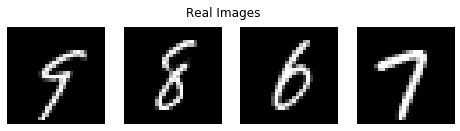

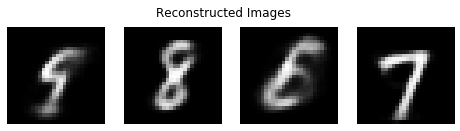

In [36]:
# 可视化最后一个测试集批次的前4个样本
fig1 = plt.figure(figsize=(8,2))
for i in range(4):
    fig1.add_subplot(1,4,i+1)
    plt.imshow(np.reshape(x[i:i+1],(28,28)), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
fig1.suptitle('Real Images')
fig2 = plt.figure(figsize=(8,2))   
fig2.suptitle('Reconstructed Images')
for i in range(4):    
    fig2.add_subplot(1,4,i+1)
    model(x[i:i+1], y[i:i+1], reconstruct=True)
    plt.imshow(np.reshape(model.recon_img,(28,28)), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')